# STAT 301 Group 40 Final Report

Wasay Hayat, Juhi Grover, Qi Xu, Xuanye Zheng(Allen)

## Introduction

(add background information - Wasay)

**Overarching question:** How can various listing features as well as location and day type be used to predict the full price of accommodation of an Airbnb listing for two people and two nights in Barcelona, Paris, or Vienna?

### Data Description

We are using data on Airbnb prices in European cities, downloaded from [Kaggle](https://www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities).

Original data source: Gyódi, K.and Ł. Nawaro. Determinants of Airbnb Prices in European Cities: A Spatial Econometrics Approach (supplementary Material). Zenodo, 13 Jan. 2021, [doi:10.5281/zenodo.4446043](doi:10.5281/zenodo.4446043).

Combining data from 3 cities (Paris, Barcelona, and Vienna), we have 13,058 observations and 22 columns, including 2 new columns created for this project.

| Variable Name            | Type | Description |
|--------------------------|-------------|-------------|
| `realSum`               |Numerical| The final rental price (response variable) |
| `room_type`             |Categorical| Type of room (private/shared/entire home/apt) |
| `room_shared`, `room_private`| Categorical (Binary)| Room is private or not |
| `multi` |Categorical (Binary)| indicator whether listing is for multiple rooms or not|
| `biz`|Categorical (Binary)| business indicator|
| `person_capacity`       |Numerical| Maximum number of guests allowed |
| `host_is_superhost`     |Categorical (Binary)| Whether the host is a "superhost" (TRUE/FALSE) |
| `cleanliness_rating`    |Numerical| Rating of cleanliness (1-10) |
| `guest_satisfaction_o`  |Numerical| Overall guest satisfaction score |
| `bedrooms`             |Numerical| Number of bedrooms available |
| `dist`, `metro_dist`   |Numerical| Distance from the city center/metro station |
| `attr_index`, `attr_index_norm`      |Numerical| Index and Normalized index of nearby attractions |
| `rest_index`, `rest_index_norm`      |Numerical| Index and Normalized index of nearby restaurants |
| `lng`, `lat`           |Numerical| Geolocation coordinates (longitude & latitude) |
| `city`           |Categorical| Paris or Barcelona or Vienna |
| `day_type`           |Categorical| weekdays or weekends|

## Methods and Results

### Exploratory Data Analysis

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(glmnet)

library(caret)
library(dplyr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.2.1     ✔ tune         1.2.1
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.1.0
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [3]:
# Main developer: Wasay

barcelona_weekdays <- read_csv("https://raw.githubusercontent.com/awhayat/stat-301-project/refs/heads/main/barcelona_weekdays.csv") |>
    mutate(city = "Barcelona", day_type = "weekday")
barcelona_weekends <- read_csv("https://raw.githubusercontent.com/awhayat/stat-301-project/refs/heads/main/barcelona_weekends.csv") |>
    mutate(city = "Barcelona", day_type = "weekend")
paris_weekdays <- read_csv("https://raw.githubusercontent.com/awhayat/stat-301-project/refs/heads/main/paris_weekdays.csv") |>
    mutate(city = "Paris", day_type = "weekday")
paris_weekends <- read_csv("https://raw.githubusercontent.com/awhayat/stat-301-project/refs/heads/main/paris_weekends.csv") |>
    mutate(city = "Paris", day_type = "weekend")
vienna_weekdays <- read_csv("https://raw.githubusercontent.com/awhayat/stat-301-project/refs/heads/main/vienna_weekdays.csv") |>
    mutate(city = "Vienna", day_type = "weekday")
vienna_weekends <- read_csv("https://raw.githubusercontent.com/awhayat/stat-301-project/refs/heads/main/vienna_weekends.csv") |>
    mutate(city = "Vienna", day_type = "weekend")

airbnb_data <- bind_rows(paris_weekdays, paris_weekends, barcelona_weekdays, barcelona_weekends, vienna_weekdays, vienna_weekends)
head(airbnb_data)

New names:
• `` -> `...1`
Rows: 1555 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): room_type
dbl (16): ...1, realSum, person_capacity, multi, biz, cleanliness_rating, gu...
lgl  (3): room_shared, room_private, host_is_superhost

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 1278 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): room_type
dbl (16): ...1, realSum, person_capacity, multi, biz, cleanliness_rating, gu...
lgl  (3): room_shared, room_private, host_is_superhost

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 3130 Columns: 20
── Column specification ─────────────────

...1,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,⋯,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,day_type
<dbl>,<dbl>,<chr>,<lgl>,<lgl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0,296.1599,Private room,FALSE,TRUE,2,TRUE,0,0,10,⋯,0.6998206,0.1937094,518.4789,25.23938,1218.6622,71.60803,2.35385,48.86282,Paris,weekday
1,288.2375,Private room,FALSE,TRUE,2,TRUE,0,0,10,⋯,2.1000054,0.1072207,873.2170,42.50791,1000.5433,58.79146,2.32436,48.85902,Paris,weekday
2,211.3431,Private room,FALSE,TRUE,2,FALSE,0,0,10,⋯,3.3023251,0.2347238,444.5561,21.64084,902.8545,53.05131,2.31714,48.87475,Paris,weekday
3,298.9561,Entire home/apt,FALSE,FALSE,2,FALSE,0,1,9,⋯,0.5475667,0.1959965,542.1420,26.39129,1199.1842,70.46351,2.35600,48.86100,Paris,weekday
4,247.9262,Entire home/apt,FALSE,FALSE,4,FALSE,0,0,7,⋯,1.1979209,0.1035729,406.9290,19.80916,1070.7755,62.91827,2.35915,48.86648,Paris,weekday
5,527.0761,Entire home/apt,FALSE,FALSE,4,TRUE,0,0,10,⋯,1.5432015,0.5491303,967.4781,47.09651,1095.8704,64.39284,2.33201,48.85891,Paris,weekday


#### Change Variable Types (as needed)

In [4]:
#Main Developer: Juhi
#Convert City, Room Type and Day Type into factors
airbnb_data$city <- as.factor(airbnb_data$city)
airbnb_data$day_type <- as.factor(airbnb_data$day_type)
airbnb_data$room_type <- as.factor(airbnb_data$room_type)

#### Handling Negative Values, Missing Values and Outliers

In [26]:
#Main Developer: Juhi
#Drop NAs or blank values
airbnb_data <- drop_na(airbnb_data)

#Remove negative values for realSum, if any
airbnb_data <- airbnb_data[airbnb_data$realSum >= 0, ]

#Identifying Outliers with Z-scores. An observation with a z-score greater than 3 or less than -3 can be considered an outlier.
z_scores <- (airbnb_data$realSum - mean(airbnb_data$realSum)) / sd(airbnb_data$realSum)

outliers_index <- abs(z_scores) > 3

#Remove Outliers
airbnb_data <- airbnb_data[!outliers_index, ]

## Variable selection

#### Explanation of Our Process

Main Contributor: Juhi

Our variable selection process aims to select the best possible variables for our analysis using the lasso model. Our process follows the following steps:
- We start by splitting the data into testing and training sets (70% training, 30% testing)
- We then check for: normality of the residual, homoschedasticity and linearity.
- We then begin our lasso process by choosing the best value for lambda
- Once lambda is chosen, we predict the values of our training data based on our model.
- We finally calculate our RMSE, MAE and R^2. 

#### Variable Selection Process

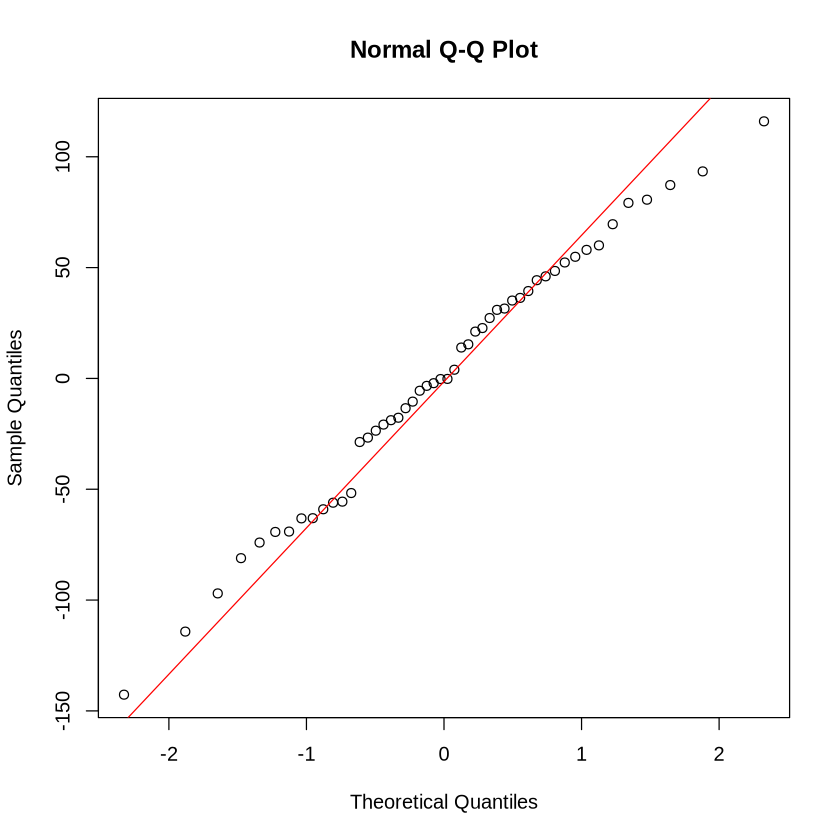

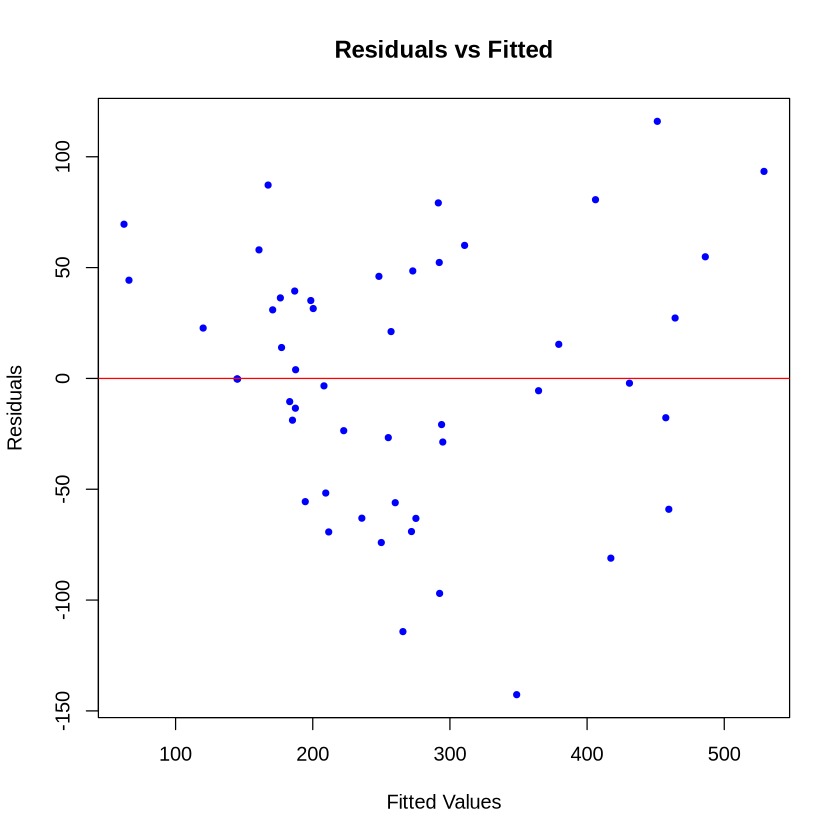

In [27]:
set.seed(123)

#Main Developer: Qi

#Remove more values based on the IQR 
Q1 <- quantile(airbnb_data$realSum, 0.25)
Q3 <- quantile(airbnb_data$realSum, 0.75)
IQR_value <- Q3 - Q1
lower_bound <- Q1 - 1.5 * IQR_value
upper_bound <- Q3 + 1.5 * IQR_value
filtered_data <- airbnb_data[airbnb_data$realSum >= lower_bound & airbnb_data$realSum <= upper_bound, ]

n <- nrow(filtered_data)
train_idx <- sample(1:n, size = 0.7 * n)

train_data <- filtered_data[train_idx, ]
test_data  <- filtered_data[-train_idx, ]

#Check for Normality of residual
sampled_data <- train_data %>%
  sample_n(50)
lm_model <- lm(realSum ~ ., data = sampled_data)
lm_residuals <- residuals(lm_model)
lm_fitted <- fitted(lm_model)
qqnorm(lm_residuals)
qqline(lm_residuals, col = "red")

#Check for Homoscedasticity and linearity
plot(lm_fitted, lm_residuals, 
     main = "Residuals vs Fitted", 
     xlab = "Fitted Values", 
     ylab = "Residuals",
     pch = 20, col = "blue")
abline(h = 0, col = "red")

[1] "Best lambda value: 0.0796624933860052"
24 x 1 sparse Matrix of class "dgCMatrix"
                                      s0
(Intercept)                 2.813037e+01
...1                       -3.809288e-03
room_typePrivate room      -6.575495e+01
room_typeShared room       -1.987579e+02
room_sharedTRUE             .           
room_privateTRUE           -3.117771e+00
person_capacity             2.995710e+01
host_is_superhostTRUE       1.074143e+01
multi                       1.613832e+01
biz                         4.169552e+01
cleanliness_rating          1.087546e+01
guest_satisfaction_overall  .           
bedrooms                    3.758236e+01
dist                        1.470073e-01
metro_dist                 -2.709158e+00
attr_index                 -1.564607e-01
attr_index_norm             6.348807e+00
rest_index                 -9.079039e-03
rest_index_norm             1.206898e+00
lng                        -5.526240e+00
lat                         .           
cityParis   

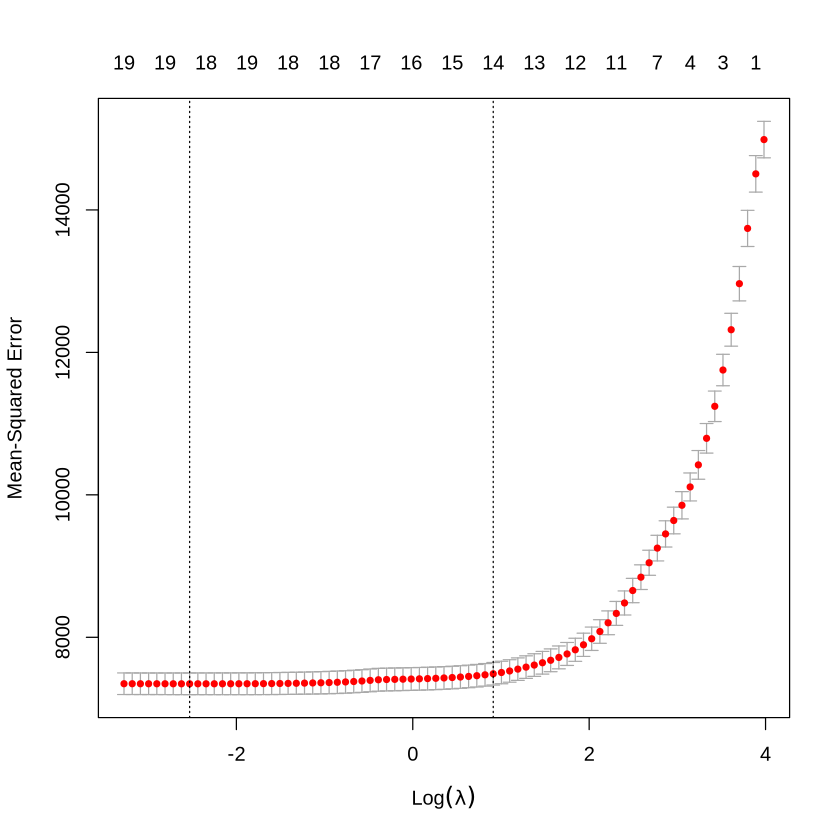

In [28]:
X <- model.matrix(realSum ~ ., data = train_data)[, -1]
y <- train_data$realSum

#Cv validate lasso
cv.lasso <- cv.glmnet(X, y, alpha = 1)

#Plot cv to see every lambda
plot(cv.lasso)

# Choose best lambda
best_lambda <- cv.lasso$lambda.min
print(paste("Best lambda value:", best_lambda))

# Fit lasso model
lasso_model <- glmnet(X, y, alpha = 1, lambda = best_lambda)
print(coef(lasso_model))

# Predict
X_test <- model.matrix(realSum ~ ., data = test_data)[, -1]
y_test <- test_data$realSum

y_pred <- predict(lasso_model, newx = X_test)

rmse <- sqrt(mean((y_test - y_pred)^2))
mae <- mean(abs(y_test - y_pred))
r2 <- 1 - sum((y_test - y_pred)^2) / sum((y_test - mean(y_test))^2)
cat("Test RMSE:", round(rmse, 2), "\n")
cat("Test MAE:", round(mae, 2), "\n")
cat("Test R-squared:", round(r2, 4), "\n")

## Discussion

Main Contributor: Xuanye Zheng

Our project focused on predicting Airbnb rental prices using data from Paris, Barcelona, and Vienna. We addressed issues such as *missing values*, *negative prices*, and *outliers*. To reduce multicollinearity and select the most predictive variables, we used **Lasso regression**, which regularizes the model by penalizing less informative features. This process helped us to identify which features had the greatest influence on the final rental price (realSum). Among those retained by the Lasso model were `room_type`, `person_capacity`, `host_is_superhost`, `bedrooms`, `biz`, `cleanliness_rating`, and various attraction and location-related indices. Obviously, variables such as `metro_dist`, `rest_index`, and even `city` were not selected, which suggests either redundancy with other features or minimal marginal contribution to price prediction. Overall, the results were mostly in line with our expectations. Features like room_type, bedrooms, and person_capacity were strong predictors of price, which aligns with typical Airbnb pricing logic.

Our final model get a test `RMSE` of 89.2, `MAE` of 67.53, and an `R-squared` of 0.512. This means that around 51% of the variance in rental prices could be explained by the included predictors. While this is a moderate level of accuracy, it highlights the complexity of Airbnb pricing, which can be influenced by many external or unobserved factors not captured in the dataset. For instance, seasonality, reviews, or nearby events.

Looking ahead, the model could be improved by creating interaction terms or combining multiple distance-based variables into a unified measure of centrality. One area worth that is worth to explore is how seasonality and event-based demand affect Airbnb prices, especially in tourist-heavy cities.

## References

(at least two references expected in the introduction)

- reference 1
- reference 2